In [ ]:
!curl -o dataset.zip https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/ccr8cm22vz-1.zip
!unzip dataset.zip
!unrar x "/content/Anemia Detection using Palpable Palm Image Datasets from Ghana/Palm.rar" > op

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  231M  100  231M    0     0  13.3M      0  0:00:17  0:00:17 --:--:-- 16.5M
Archive:  dataset.zip
  inflating: Anemia Detection using Palpable Palm Image Datasets from Ghana/Palm.rar  


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [ ]:
import os
import cv2
from tqdm import tqdm

anemic = []
non_anemic = []
for filename in tqdm(os.listdir('/content/Palm/')):
  if 'Non' in filename:
    non_anemic.append(filename)
  else:
    anemic.append(filename)

# print(anemic, "\n",non_anemic)

100%|██████████| 4260/4260 [00:00<00:00, 1054765.94it/s]


In [ ]:
def read_img(filepath):
  img = cv2.imread(filepath)
  img = cv2.resize(img, (400, 400))
  # img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
  # l, a, b = img[:, :, 0], img[:, :, 1], img[:, :, 2]
  # return b
  return img

In [ ]:
dataset = []
labels = []
path = '/content/Palm/'
for filename in tqdm(anemic):
  labels.append(0)
  img = read_img(os.path.join(path, filename))
  dataset.append(img)
for filename in tqdm(non_anemic):
  labels.append(1)
  img = read_img(os.path.join(path, filename))
  dataset.append(img)

100%|██████████| 1698/1698 [00:04<00:00, 360.73it/s]


In [ ]:
dataset = np.array(dataset)
labels = np.array(labels)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
filepath = "/content/drive/MyDrive/bgr-good-0.83-alexnet.h5"
model = keras.saving.load_model(filepath)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 128)       46592     
                                                                 
 batch_normalization (BatchN  (None, 98, 98, 128)      512       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 49, 49, 256)       819456    
                                                                 
 batch_normalization_1 (Batc  (None, 49, 49, 256)      1024      
 hNormalization)                                                 
                                                        

In [ ]:
pred_vecs = model.predict(dataset)

134/134 [==============================] - 13s 27ms/step


In [ ]:
pred = tf.argmax(pred_vecs, axis=1)

In [ ]:
class_0 = []
class_1 = []

In [ ]:
for t, p, img in zip(labels, pred, dataset):
  if t == p:
    if t == 0:
      class_0.append(img)
    else:
      class_1.append(img)

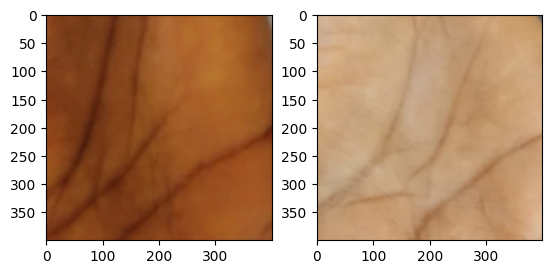

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import cm, colormaps
plt.subplot(1, 2, 1)
plt.imshow(class_0[0][:, :, ::-1])
plt.subplot(1, 2, 2)
plt.imshow(class_1[0][:, :, ::-1])

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
def save_and_display_gradcam(img, heatmap, alpha=0.4):
    # Rescale heatmap to a range 0-255
    img = img[:, :, ::-1]
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    # jet = cm.get_cmap("jet")
    jet = colormaps['jet']

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    # superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    # superimposed_img.save(cam_path)
    # plt.imshow(superimposed_img/np.max(superimposed_img))
    # plt.imsave(superimposed_img/np.max(superimposed_img))
    # plt.show()
    return superimposed_img/np.max(superimposed_img)


In [ ]:
# idx = 500
for idx in tqdm(range(len(class_0))):
  img = class_0[idx]
  model.layers[-1].activation = None
  heatmap = make_gradcam_heatmap(np.expand_dims(img, 0), model, 'max_pooling2d_2')
  grad_cam_img = save_and_display_gradcam(img, heatmap, )
  plt.imsave(f"/content/drive/MyDrive/GradCAM/Anemia/{idx}.png", grad_cam_img)
# plt.show()

for idx in tqdm(range(len(class_1))):
  img = class_1[idx]
  model.layers[-1].activation = None
  heatmap = make_gradcam_heatmap(np.expand_dims(img, 0), model, 'max_pooling2d_2')
  grad_cam_img = save_and_display_gradcam(img, heatmap, )
  plt.imsave(f"/content/drive/MyDrive/GradCAM/Non-anemia/{idx}.png", grad_cam_img)

100%|██████████| 1304/1304 [02:58<00:00,  7.29it/s]


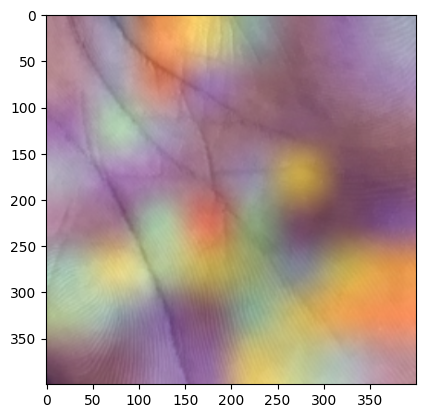

In [ ]:
plt.imshow(grad_cam_img)